In [6]:
using Pkg; Pkg.activate(".")
#pkg"add MatrixProductBP, Graphs, IndexedGraphs, Statistics, Random, StatsBase, ProgressMeter, JLD2, TensorTrains, LinearAlgebra, LaTeXStrings, PyPlot, PyCall"
#pkg"add https://github.com/Mattiatarabolo/SmallCouplingDynamicCavity.jl"
Pkg.status()

Status `~/Desktop/julia_codes/SmallCouplingDynamicCavity.jl/examples/SIRS_inference/Project.toml`
  [86223c79] Graphs v1.12.0
  [8a731c18] IndexedGraphs v0.6.1
  [033835bb] JLD2 v0.5.11
  [b964fa9f] LaTeXStrings v1.4.0
  [3d39929c] MatrixProductBP v0.9.0
  [92933f4c] ProgressMeter v1.10.2
  [438e738f] PyCall v1.96.4
  [d330b81b] PyPlot v2.11.5
  [1607259e] SmallCouplingDynamicCavity v4.0.2 `https://github.com/Mattiatarabolo/SmallCouplingDynamicCavity.jl#main`
  [2913bbd2] StatsBase v0.34.4
  [89893e69] TensorTrains v0.12.1
  [37e2e46d] LinearAlgebra
  [9a3f8284] Random
  [10745b16] Statistics v1.10.0


  Activating project at `~/Desktop/julia_codes/SmallCouplingDynamicCavity.jl/examples/SIRS_inference`


In [8]:
import MatrixProductBP as MPBP
import MatrixProductBP.Models as MPBPm
import SmallCouplingDynamicCavity as SCDC
using Graphs, IndexedGraphs, Statistics, Random, StatsBase
using ProgressMeter; ProgressMeter.ijulia_behavior(:clear)
using JLD2
using TensorTrains: summary_compact;
using LinearAlgebra
using LaTeXStrings
import PyPlot as plt
using PyCall

In [9]:
# Define the saving structure, in which the results will be saved
struct SaveStruct
    s::Int
    ε_autoinf::Float64
    maxiter::Union{Int,Array{Int}}
    damp::Union{Float64,Array{Float64}}
    μ_cutoff::Float64
    fpn::Float64
    n_iter_nc::Int
    damp_nc::Float64
    fMAP_true::Float64

    SaveStruct(s) = new(s, 0.0, 0, 0.0, 0.0, 0.0, 0, 0.0, 0.0)
    SaveStruct(s, ε_autoinf, maxiter, damp, μ_cutoff, fpn, n_iter_nc, damp_nc, fMAP_true) = new(s, ε_autoinf, maxiter, damp, μ_cutoff, fpn, n_iter_nc, damp_nc, fMAP_true)
end

to_rgba(col, alpha) = plt.matplotlib.colors.to_rgba(col, alpha)

to_rgba (generic function with 1 method)

In [12]:
T = 20
N = 100
c = 2.5

ρ = 0.15
σ = 0.15
n_sr = 2
γ = n_sr/N

of = 0.75 #observation fractions
n_obs = floor(Int, N * of)
obs_time = 10

λs = 0.1:0.05:0.6
ks = 1:4

1:4

In [14]:
res_mpbp, seeds = load("points_seeds.jld2", "points", "seeds")
res_scdc = load_object("res_scdc.jld2")

nseeds_mpbp = 50
nseeds_scdc = 50

# Function to plot MPBP results
function plotres_mpbp!(ax, points, col, lab, marker)
    p = vec(points[1])
    error = vec(points[2])
    lower = p .- error
    upper = p .+ error
    
    # Plot with error bars
    ax.plot(λs, p, label=lab, marker=marker, color=to_rgba(col, .5), linestyle="--", linewidth=1, markerfacecolor=to_rgba(col, 1), markeredgecolor=to_rgba("dimgray", 1), markeredgewidth=.5, markersize=5)
    
    # Add ribbon
    ax.fill_between(λs, lower, upper, facecolor=to_rgba(col, .2), edgecolor=to_rgba(col, 0), label="")
end

# Function to plot SCDC results
function plotres_scdc!(ax, points, col, lab)
    p = vec(points[1])
    error = vec(points[2])
    lower = p .- error
    upper = p .+ error
    
    # Plot with error bars
    ax.plot(λs, p, label=lab, marker="*", color=to_rgba(col, .5), linestyle="--", linewidth=1, markerfacecolor=to_rgba(col, 1), markeredgecolor=to_rgba("dimgray", 1), markeredgewidth=.5, markersize=5)
     
    # Add ribbon
    ax.fill_between(λs, lower, upper, facecolor=to_rgba(col, .2), edgecolor=to_rgba(col, 0))
end

# Initialize plot
fig, ax = plt.subplots(figsize=(3.4, 3))
rcParams = PyDict(plt.matplotlib["rcParams"])
rcParams["font.size"] = 8  #9 18

ax.set_xlabel(L"\lambda")
ax.set_ylabel("Fraction of correct MAP predictions")

# Plot MPBP results
markers = ["o", "s", "h", "d"]  # circle, square, hexagon, diamond
foreach(k -> plotres_mpbp!(ax, res_mpbp[k], "C$(k)", "MPBP, "*L"M="*"$k", markers[k]), ks)

# Plot SCDC results
#plotres_scdc!(ax, res_scdc, "blue", "SCDC")

# Set plot limits and show legend
ax.set_ylim(0.5, 1.0)
ax.set_yticks(0.5:0.1:1.0)
ax.grid(alpha=.2)
ax.legend()
#plt.show()
fig.savefig("MAP_comparison_ribbon.pdf", bbox_inches="tight")

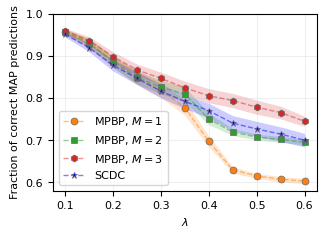

In [16]:
nseeds_mpbp = 50
nseeds_scdc = 50

# Function to plot MPBP results
function plotres_mpbp!(ax, points, col, lab, marker)
    p = vec(points[1])
    p2 = vec(points[2])
    error = sqrt.((p2 .- p.^2)/nseeds_mpbp)
    lower = p .- error
    upper = p .+ error
    
    # Plot with error bars
    ax.plot(λs, p, label=lab, marker=marker, color=to_rgba(col, .5), linestyle="--", linewidth=1, markerfacecolor=to_rgba(col, 1), markeredgecolor=to_rgba("dimgray", 1), markeredgewidth=.5, markersize=5)
    
    # Add ribbon
    ax.fill_between(λs, lower, upper, facecolor=to_rgba(col, .2), edgecolor=to_rgba(col, 0), label="")
end

# Function to plot SCDC results
function plotres_scdc!(ax, points, col, lab)
    p = vec(points[1])
    error = vec(points[2])
    lower = p .- error
    upper = p .+ error
    
    # Plot with error bars
    ax.plot(λs, p, label=lab, marker="*", color=to_rgba(col, .5), linestyle="--", linewidth=1, markerfacecolor=to_rgba(col, 1), markeredgecolor=to_rgba("dimgray", 1), markeredgewidth=.5, markersize=5)
     
    # Add ribbon
    ax.fill_between(λs, lower, upper, facecolor=to_rgba(col, .2), edgecolor=to_rgba(col, 0))
end

# Initialize plot
fig, ax = plt.subplots(figsize=(3.4, 2.3))
rcParams = PyDict(plt.matplotlib["rcParams"])
rcParams["font.size"] = 8  #9 18

ax.set_xlabel(L"\lambda")
ax.set_ylabel("Fraction of correct MAP predictions")

# Plot MPBP results
markers = ["o", "s", "h", "d"]  # circle, square, hexagon, diamond
foreach(k -> plotres_mpbp!(ax, res_mpbp[k], "C$(k)", "MPBP, "*L"M="*"$k", markers[k]), ks)

# Plot SCDC results
plotres_scdc!(ax, res_scdc, "blue", "SCDC")

# Set plot limits and show legend
ax.set_ylim(0.58, 1.0)
ax.set_yticks(0.6:0.1:1.0)
ax.grid(alpha=.2)
ax.legend()
#plt.show()
fig.savefig("MAP_comparison_ribbon.pdf", bbox_inches="tight")